In [320]:
import json
import json5
import demjson

In [321]:
with open('../../data/australian_user_reviews.json', 'r') as f:
    # user_reviews = demjson.decode(f.read())
    user_reviews = json.load(f)


In [322]:

with open('../../data/australian_users_items.json', 'r') as f:
    # user_items = demjson.decode(f.read())
    user_items = json.load(f)


In [323]:
with open('../../data/steam_games.json', 'r') as f:
    # steam_games = demjson.decode(f.read())
    steam_games = json.load(f)

# with open('../../data/steam_review.json', 'r') as f:
#     steam_reviews = demjson.decode(f.read())

In [324]:
steam_games[0]

{'publisher': 'Kotoshiro',
 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'],
 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/',
 'release_date': '2018-01-04',
 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'],
 'discount_price': 4.49,
 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player'],
 'price': 4.99,
 'early_access': False,
 'id': '761140',
 'developer': 'Kotoshiro'}

In [325]:
user_reviews[0]

{'user_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'reviews': [{'funny': '',
   'posted': 'Posted November 5, 2011.',
   'last_edited': '',
   'item_id': '1250',
   'helpful': 'No ratings yet',
   'recommend': True},
  {'funny': '',
   'posted': 'Posted July 15, 2011.',
   'last_edited': '',
   'item_id': '22200',
   'helpful': 'No ratings yet',
   'recommend': True},
  {'funny': '',
   'posted': 'Posted April 21, 2011.',
   'last_edited': '',
   'item_id': '43110',
   'helpful': 'No ratings yet',
   'recommend': True}]}

In [326]:
steam_games[0]

{'publisher': 'Kotoshiro',
 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'],
 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/',
 'release_date': '2018-01-04',
 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'],
 'discount_price': 4.49,
 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player'],
 'price': 4.99,
 'early_access': False,
 'id': '761140',
 'developer': 'Kotoshiro'}

In [327]:
game_details = {
    game.get('id', None): {
        'developer': game.get('developer', None),
        'tags': game.get('tags', None)
    } for game in steam_games if game.get('id') is not None 
}




user_data_map = {}

for user in user_reviews:
    user_id = user['user_id']
    user_data_map[user_id] = {
        'reviews': {},
        'items': {}
    }

    for review in user['reviews']:
        game_id = review['item_id']
        game_info = game_details.get(game_id, {})
        user_data_map[user_id]['reviews'][game_id] = {
            'posted': review['posted'],
            'recommend': review['recommend']
        }




for user in user_items:
    user_id = user['user_id']
    if user_id in user_data_map: 
        for item in user['items']:
            game_id = item['item_id']
            game_info = game_details.get(game_id, {})
            if user_id not in user_data_map:
                user_data_map[user_id] = {
                    'reviews': {},
                    'items': {}
                }
            user_data_map[user_id]['items'][game_id] = {
                'game_id': game_id,
                'playtime_forever': item['playtime_forever'],
            }


In [328]:
for k, v in user_data_map.items():
    if len(v['items']) > 0:
        print(k, v)
        break

for k, v in game_details.items():
    print(k, v)
    break

MeaTCompany {'reviews': {'730': {'posted': 'Posted July 24.', 'recommend': True}}, 'items': {'240': {'game_id': '240', 'playtime_forever': 3209}, '500': {'game_id': '500', 'playtime_forever': 390}, '620': {'game_id': '620', 'playtime_forever': 43}, '105600': {'game_id': '105600', 'playtime_forever': 416}, '207490': {'game_id': '207490', 'playtime_forever': 278}, '208480': {'game_id': '208480', 'playtime_forever': 67}, '202970': {'game_id': '202970', 'playtime_forever': 832}, '202990': {'game_id': '202990', 'playtime_forever': 2176}, '212910': {'game_id': '212910', 'playtime_forever': 91}, '38830': {'game_id': '38830', 'playtime_forever': 0}, '99900': {'game_id': '99900', 'playtime_forever': 183}, '104700': {'game_id': '104700', 'playtime_forever': 0}, '304930': {'game_id': '304930', 'playtime_forever': 3}, '730': {'game_id': '730', 'playtime_forever': 18481}}}
761140 {'developer': 'Kotoshiro', 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']}


In [329]:
def get_user_game_playtime(user_data_map, user_id, game_id):
    """
    获取用户在特定游戏的总游戏时长
    
    参数:
    - user_data_map: 用户游戏数据映射
    - user_id: 用户ID
    - game_id: 游戏ID
    
    返回:
    - 游戏时长（分钟），如果没有找到则返回0
    """
    # 检查用户是否存在于用户数据映射中
    if user_id not in user_data_map:
        return 0
    
    # 检查用户是否玩过该游戏
    user_items = user_data_map[user_id].get('items', {})
    if game_id not in user_items:
        return 0
    
    # 返回游戏时长
    return user_items[game_id].get('playtime_forever', 0)


def get_game_tags(game_details, game_id):
    """
    获取游戏的标签
    
    参数:
    - game_details: 游戏详情数据
    - game_id: 游戏ID
    
    返回:
    - 游戏标签列表，如果没有找到则返回空列表
    """
    # 检查游戏是否存在于游戏详情数据中
    if game_id not in game_details:
        return []
    
    tags = game_details[game_id].get('tags', [])
    return tags if tags else []


def get_game_developer(game_details, game_id):
    """
    获取游戏的开发者
    
    参数:
    - game_details: 游戏详情数据
    - game_id: 游戏ID
    
    返回:
    - 游戏开发者，如果没有找到则返回空字符串
    """
    # 检查游戏是否存在于游戏详情数据中
    if game_id not in game_details:
        return ''
    
    return game_details[game_id].get('developer', '')


def get_tags_user_played(user_data_map, user_id):
    """
    获取用户玩过的游戏标签
    
    参数:
    - user_data_map: 用户游戏数据映射
    - user_id: 用户ID
    
    返回:
    - 用户玩过的游戏标签列表
    """
    # 检查用户是否存在于用户数据映射中
    if user_id not in user_data_map:
        return []
    
    # 获取用户玩过的游戏ID列表
    user_items = user_data_map[user_id].get('items', {})
    game_ids = user_items.keys()
    
    # 获取用户玩过的游戏标签
    tags = []
    for game_id in game_ids:
        game_tags = get_game_tags(game_details, game_id)
        if game_tags:
            tags.extend(game_tags)

    return tags

def get_developer_user_played(user_data_map, user_id):
    """
    获取用户玩过的游戏开发者
    
    参数:
    - user_data_map: 用户游戏数据映射
    - user_id: 用户ID
    
    返回:
    - 用户玩过的游戏开发者列表
    """
    # 检查用户是否存在于用户数据映射中
    if user_id not in user_data_map:
        return []
    
    # 获取用户玩过的游戏ID列表
    user_items = user_data_map[user_id].get('items', {})
    game_ids = user_items.keys()
    
    # 获取用户玩过的游戏开发者
    developers = []
    for game_id in game_ids:
        developers.append(get_game_developer(game_details, game_id))
    
    return developers


def get_user_recommend_rate(user_data_map, user_id):
    """
    获取用户推荐率
    
    参数:
    - user_data_map: 用户游戏数据映射
    - user_id: 用户ID
    
    返回:
    - 用户推荐率
    """
    # 检查用户是否存在于用户数据映射中
    if user_id not in user_data_map:
        return 0
    
    # 获取用户的所有评价
    user_reviews = user_data_map[user_id].get('reviews', {})
    reviews = user_reviews.values()
    
    # 计算用户的推荐率
    total_reviews = len(reviews)
    if total_reviews == 0:
        return 0
    
    total_recommend = 0
    for review in reviews:
        total_recommend += review.get('recommend', False)
    
    return total_recommend / total_reviews


def get_game_recommend_rate(user_data_map, game_id):
    """
    获取游戏的推荐率
    
    参数:
    - user_data_map: 用户游戏数据映射
    - game_id: 游戏ID
    
    返回:
    - 游戏推荐率
    """
    # 获取玩过该游戏的用户ID列表
    user_ids = [user_id for user_id, user_data in user_data_map.items() if game_id in user_data['items']]
    
    # 计算游戏的推荐率
    total_users = len(user_ids)
    if total_users == 0:
        return 0
    
    total_recommend = 0
    for user_id in user_ids:
        total_recommend += get_user_recommend_rate(user_data_map, user_id)
    
    return total_recommend / total_users


def get_game_jaccard_similarity(game_id_1, game_id_2):
    """
    获取两个游戏的Jaccard相似度
    
    参数:
    - game_id_1: 游戏ID1
    - game_id_2: 游戏ID2
    
    返回:
    - 两个游戏的Jaccard相似度
    """
    # 获取两个游戏的标签
    tags_1 = set(get_game_tags(game_details, game_id_1))
    tags_2 = set(get_game_tags(game_details, game_id_2))
    
    # 计算Jaccard相似度
    union = tags_1.union(tags_2)
    intersection = tags_1.intersection(tags_2)
    return len(intersection) / len(union) if len(union) > 0 else 0


def get_user_jaccard_similarity(user_id_1, user_id_2):
    """
    获取两个用户的Jaccard相似度
    
    参数:
    - user_id_1: 用户ID1
    - user_id_2: 用户ID2
    
    返回:
    - 两个用户的Jaccard相似度
    """
    # 获取两个用户的标签
    tags_1 = set(get_tags_user_played(user_data_map, user_id_1))
    tags_2 = set(get_tags_user_played(user_data_map, user_id_2))
    
    # 计算Jaccard相似度
    union = tags_1.union(tags_2)
    intersection = tags_1.intersection(tags_2)
    return len(intersection) / len(union) if len(union) > 0 else 0


In [330]:
# test get_user_game_playtime
print(get_user_game_playtime(user_data_map, 'MeaTCompany', '304930'))  

# test get_game_tags
print(get_game_tags(game_details, '304930'))

# test get_game_developer
print(get_game_developer(game_details, '304930'))

# test get_tags_user_played
print(get_tags_user_played(user_data_map, 'MeaTCompany'))

# test get_developer_user_played
print(get_developer_user_played(user_data_map, 'MeaTCompany'))

# test get_user_recommend_rate
print(get_user_recommend_rate(user_data_map, 'MeaTCompany'))

# test get_game_recommend_rate
print(get_game_recommend_rate(user_data_map, '304930'))

# test get_game_jaccard_similarity
print(get_game_jaccard_similarity('304930', '570940'))

# test get_user_jaccard_similarity
print(get_user_jaccard_similarity('MeaTCompany', '76561198035864385'))

3
['Free to Play', 'Survival', 'Zombies', 'Multiplayer', 'Open World', 'Adventure', 'Crafting', 'Action', 'First-Person', 'Co-op', 'Sandbox', 'Post-apocalyptic', 'Shooter', 'FPS', 'Singleplayer', 'Massively Multiplayer', 'Indie', 'Atmospheric', 'Casual', 'Horror']
Smartly Dressed Games
['Action', 'FPS', 'Multiplayer', 'Shooter', 'Team-Based', 'Tactical', 'First-Person', 'Competitive', 'PvP', 'Military', 'War', 'e-sports', 'Moddable', 'Strategy', 'Difficult', 'Singleplayer', 'Survival', 'Simulation', 'Atmospheric', 'Sandbox', 'Zombies', 'Co-op', 'FPS', 'Action', 'Multiplayer', 'Shooter', 'Online Co-Op', 'Team-Based', 'First-Person', 'Horror', 'Survival', 'Post-apocalyptic', 'Singleplayer', 'Atmospheric', 'Adventure', 'Tactical', 'Competitive', 'Moddable', 'Female Protagonist', 'Replay Value', 'Puzzle', 'Co-op', 'First-Person', 'Sci-fi', 'Comedy', 'Singleplayer', 'Adventure', 'Online Co-Op', 'Funny', 'Science', 'Female Protagonist', 'Action', 'Story Rich', 'Multiplayer', 'Atmospheric', '

In [331]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def extract_features(user_id, game_id):
    """
    提取用户和游戏的特征
    """
    features = {}
    
    features["playtime"] = get_user_game_playtime(user_data_map, user_id, game_id)

    user_tags = set(get_tags_user_played(user_data_map, user_id))
    game_tags = set(get_game_tags(game_details, game_id))
    features["tag_similarity"] = len(user_tags.intersection(game_tags)) / len(user_tags.union(game_tags)) if user_tags and game_tags else 0

    game_dev = get_game_developer(game_details, game_id)
    user_devs = set(get_developer_user_played(user_data_map, user_id))
    features["developer_similarity"] = 1 if game_dev in user_devs else 0

    features["game_recommend_rate"] = get_game_recommend_rate(user_data_map, game_id)

    features["user_recommend_rate"] = get_user_recommend_rate(user_data_map, user_id)

    recommended_games = [g_id for g_id in user_data_map[user_id].get('items', {}).keys() if user_data_map[user_id]['reviews'].get(g_id, {}).get('recommend', False)]
    game_jaccard = [get_game_jaccard_similarity(game_id, rec_game) for rec_game in recommended_games]
    features["game_jaccard_similarity"] = np.mean(game_jaccard) if game_jaccard else 0

    recommenders = [uid for uid, udata in user_data_map.items() if game_id in udata.get('items', {}) and udata['reviews'].get(game_id, {}).get('recommend', False)]
    user_jaccard = [get_user_jaccard_similarity(user_id, recommender) for recommender in recommenders]
    features["user_jaccard_similarity"] = np.mean(user_jaccard) if user_jaccard else 0
    
    return features


In [332]:
# test extract_features
extract_features('76561197970982479', '1250')

{'playtime': 0,
 'tag_similarity': 0,
 'developer_similarity': 0,
 'game_recommend_rate': 0.9242888888888889,
 'user_recommend_rate': 1.0,
 'game_jaccard_similarity': 0,
 'user_jaccard_similarity': np.float64(0.0)}

In [318]:
X = []
y = []
for user_id, user_data in user_data_map.items():
    for game_id, game_data in user_data.get('reviews', {}).items():
        features = extract_features(user_id, game_id)
        X.append(features)
        
        is_recommended = user_data['reviews'].get(game_id, {}).get('recommend', False)
        y.append(1 if is_recommended else 0)

X = pd.DataFrame(X)
y = np.array(y)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=500),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    # "SVM": SVC(class_weight="balanced", random_state=42, probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=500),
    "XGBoost": XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
}

for model_name, model in models.items():
    print(f"===== {model_name} =====")
    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = model.predict(X_test_resampled)
    
    acc = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    f1 = f1_score(y_test_resampled, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")

===== Logistic Regression =====
Accuracy: 0.8805
Precision: 0.8975
Recall: 0.8590
F1 Score: 0.8778


===== Gradient Boosting =====
Accuracy: 0.8626
Precision: 0.8577
Recall: 0.8695
F1 Score: 0.8636


===== KNN =====
Accuracy: 0.8144
Precision: 0.7760
Recall: 0.8841
F1 Score: 0.8265


===== XGBoost =====


/home/commcheck/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:04:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8282
Precision: 0.7868
Recall: 0.9003
F1 Score: 0.8398


===== Random Forest =====
Accuracy: 0.8327
Precision: 0.7905
Recall: 0.9052
F1 Score: 0.8440




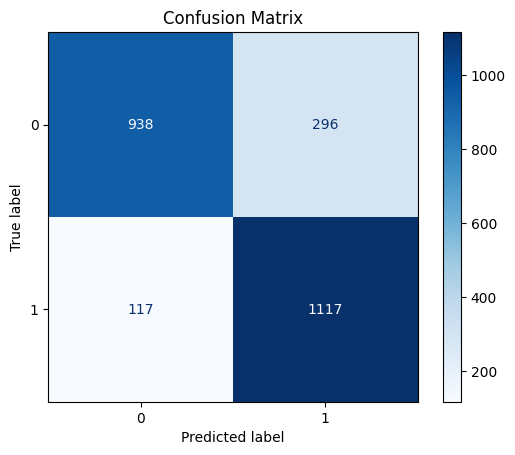

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test_resampled, y_pred, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.show()


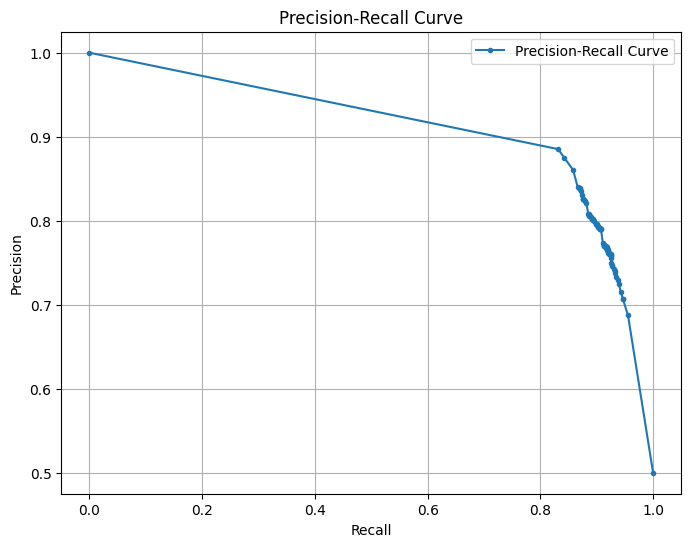

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_test_resampled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test_resampled, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


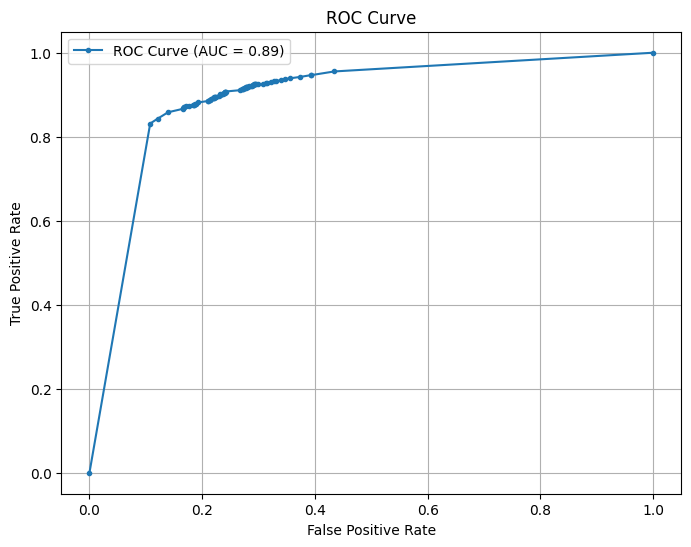

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_resampled, y_scores)
auc = roc_auc_score(y_test_resampled, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker=".", label=f"ROC Curve (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_225610/1570979720.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


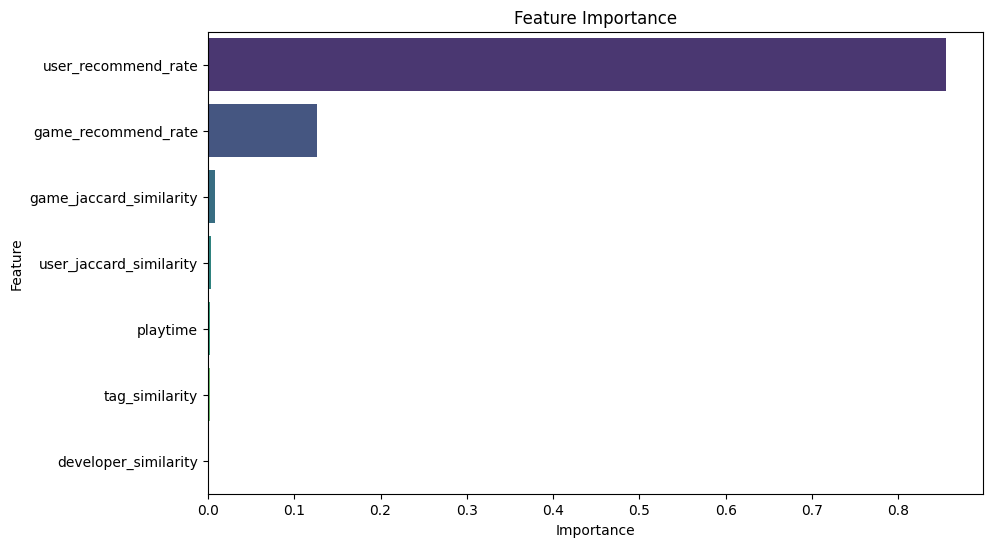

In [ ]:
import pandas as pd
import seaborn as sns

feature_importances = model.feature_importances_
features = X.columns 
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [341]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_resampled)
print("Accuracy:", accuracy_score(y_test_resampled, y_pred))
print("Precision:", precision_score(y_test_resampled, y_pred))
print("Recall:", recall_score(y_test_resampled, y_pred))
print("F1 Score:", f1_score(y_test_resampled, y_pred))

Accuracy: 0.8326580226904376
Precision: 0.7905166312809625
Recall: 0.9051863857374393
F1 Score: 0.8439743105402342


In [342]:
import random

game_ids = [game_id for game_id in game_details.keys()]
# print(all_games[:5])
print(len(game_ids))
selected_game_ids = random.sample(game_ids, 6000)

32132


In [ ]:
X_exclude = []
y_exclude = []
excluded_game_ids = set(selected_game_ids) 

for user_id, user_data in user_data_map.items():
    for game_id, game_data in user_data.get("reviews", {}).items():
        if game_id in excluded_game_ids:
            continue
        
        features = extract_features(user_id, game_id)
        X_exclude.append(features)
        
        is_recommended = user_data["reviews"].get(game_id, {}).get("recommend", False)
        y_exclude.append(1 if is_recommended else 0)

X_exclude = pd.DataFrame(X_exclude)
y_exclude = np.array(y_exclude)


数据集大小: 55260, 目标变量大小: 55260


In [344]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 划分数据集
X_exclude_train, X_exclude_test, y_exclude_train, y_exclude_test = train_test_split(X_exclude, y_exclude, test_size=0.2, random_state=42)

# 过采样和欠采样
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_exclude_test_resampled, y_exclude_test_resampled = undersampler.fit_resample(X_exclude_test, y_exclude_test)

smote_enn = SMOTEENN(random_state=42)
X_exclude_train_resampled, y_exclude_train_resampled = smote_enn.fit_resample(X_exclude_train, y_exclude_train)

# 训练模型
model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_exclude_train_resampled, y_exclude_train_resampled)

# 预测
y_exclude_pred = model.predict(X_exclude_test_resampled)
y_pred = model.predict(X_test_resampled)
print("Accuracy:", accuracy_score(y_test_resampled, y_pred))
print("Precision:", precision_score(y_test_resampled, y_pred))
print("Recall:", recall_score(y_test_resampled, y_pred))
print("F1 Score:", f1_score(y_test_resampled, y_pred))

Accuracy: 0.836709886547812
Precision: 0.7899511514305653
Recall: 0.9173419773095624
F1 Score: 0.8488938882639671


In [347]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def get_users_who_played_game(user_data_map, game_id):
    return [user_id for user_id, user_data in user_data_map.items() if game_id in user_data["items"]]

def predict_user_recommendation(model, user_id, game_id, user_data_map):
    features = extract_features(user_id, game_id)
    X = pd.DataFrame([features])
    return model.predict(X)[0]

results = []
for game_id in selected_game_ids:

    user_ids = get_users_who_played_game(user_data_map, game_id)
    if not user_ids:
        continue
    actual_recommend_rate = get_game_recommend_rate(user_data_map, game_id)
    # get rid of the game with actual recommend rate of 0 and 1
    if actual_recommend_rate == 0 or actual_recommend_rate == 1:
        continue
    print(f"Processing Game ID: {game_id}")

    predicted_recommendations = []
    for user_id in user_ids:
        prediction = predict_user_recommendation(model, user_id, game_id, user_data_map)
        predicted_recommendations.append(prediction)

    predicted_recommend_rate = sum(predicted_recommendations) / len(predicted_recommendations)

    results.append({
        "game_id": game_id,
        "actual_recommend_rate": actual_recommend_rate,
        "predicted_recommend_rate": predicted_recommend_rate,
    })

    print(f"Actual Recommend Rate: {actual_recommend_rate:.4f}")
    print(f"Predicted Recommend Rate: {predicted_recommend_rate:.4f}")

if results:
    actual_rates = [result["actual_recommend_rate"] for result in results]
    predicted_rates = [result["predicted_recommend_rate"] for result in results]

    mse = mean_squared_error(actual_rates, predicted_rates)
    mae = mean_absolute_error(actual_rates, predicted_rates)

    print("\nEvaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

Processing Game ID: 236110
Actual Recommend Rate: 0.9244
Predicted Recommend Rate: 0.8983
Processing Game ID: 373420
Actual Recommend Rate: 0.8750
Predicted Recommend Rate: 0.7500
Processing Game ID: 248570
Actual Recommend Rate: 0.9321
Predicted Recommend Rate: 0.9017
Processing Game ID: 247080
Actual Recommend Rate: 0.7500
Predicted Recommend Rate: 0.7500
Processing Game ID: 374320
Actual Recommend Rate: 0.9091
Predicted Recommend Rate: 0.9091
Processing Game ID: 41000
Actual Recommend Rate: 0.8000
Predicted Recommend Rate: 0.8000
Processing Game ID: 311480
Actual Recommend Rate: 0.5000
Predicted Recommend Rate: 0.5000
Processing Game ID: 387990
Actual Recommend Rate: 0.9242
Predicted Recommend Rate: 0.8182
Processing Game ID: 22330
Actual Recommend Rate: 0.8529
Predicted Recommend Rate: 0.8235
Processing Game ID: 32370
Actual Recommend Rate: 0.9167
Predicted Recommend Rate: 0.9167
Processing Game ID: 47410
Actual Recommend Rate: 0.9697
Predicted Recommend Rate: 0.9545
Processing Gam